In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score,confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import tqdm
seed = 42

In [4]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

## Explorative Data Analysis

In [5]:
print(f"Train data shape is:",train.shape)
print(f"Test data shape is:",test.shape)

Train data shape is: (250, 302)
Test data shape is: (19750, 301)


There are 250 data points in the train data with 302 columns while the test data has 19750 datapoints and 301 columns.

In [6]:
train.describe()

,id,target,0,1,2,3,4,5,6,7,...,290,291,292,293,294,295,296,297,298,299
count,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,...,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000
mean,124.500000,0.640000,0.023292,-0.026872,0.167404,0.001904,0.001588,-0.007304,0.032052,0.078412,...,0.044652,0.126344,0.018436,-0.012092,-0.065720,-0.106112,0.046472,0.006452,0.009372,-0.128952
std,72.312977,0.480963,0.998354,1.009314,1.021709,1.011751,1.035411,0.955700,1.006657,0.939731,...,1.011416,0.972567,0.954229,0.960630,1.057414,1.038389,0.967661,0.998984,1.008099,0.971219
min,0.000000,0.000000,-2.319000,-2.931000,-2.477000,-2.359000,-2.566000,-2.845000,-2.976000,-3.444000,...,-2.804000,-2.443000,-2.757000,-2.466000,-3.287000,-3.072000,-2.634000,-2.776000,-3.211000,-3.500000
25%,62.250000,0.000000,-0.644750,-0.739750,-0.425250,-0.686500,-0.659000,-0.643750,-0.675000,-0.550750,...,-0.617000,-0.510500,-0.535750,-0.657000,-0.818500,-0.821000,-0.605500,-0.751250,-0.550000,-0.754250
50%,124.500000,1.000000,-0.015500,0.057000,0.184000,-0.016500,-0.023000,0.037500,0.060500,0.183500,...,0.067500,0.091000,0.057500,-0.021000,-0.009000,-0.079500,0.009500,0.005500,-0.009000,-0.132500
75%,186.750000,1.000000,0.677000,0.620750,0.805000,0.720000,0.735000,0.660500,0.783250,0.766250,...,0.797250,0.804250,0.631500,0.650250,0.739500,0.493000,0.683000,0.794250,0.654250,0.503250
max,249.000000,1.000000,2.567000,2.419000,3.392000,2.771000,2.901000,2.793000,2.546000,2.846000,...,2.865000,2.801000,2.736000,2.596000,2.226000,3.131000,3.236000,2.626000,3.530000,2.771000


Train data is within a sizeable range with no outlier in sight.

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Columns: 302 entries, id to 299
dtypes: float64(301), int64(1)
memory usage: 590.0 KB


The train data are all numeric data, mostly float datatype (continuous) and only one integer.

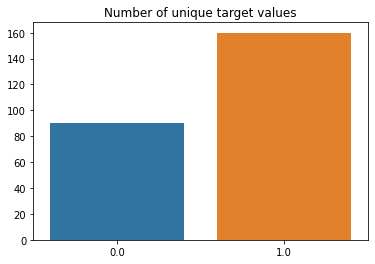

In [8]:
sns.barplot(x=train['target'].value_counts().index, y=train['target'].value_counts().values)
plt.title('Number of unique target values')
plt.show()

In [9]:
total_num = train.shape[0]
count_1, count_0 = train['target'].value_counts().values
print('Fraction of dataset contain total number of 0s:',(count_0/total_num)*100,'%')
print('Fraction of dataset contain total number of 1s:',(count_1/total_num)*100,'%')

Fraction of dataset contain total number of 0s: 36.0 %
Fraction of dataset contain total number of 1s: 64.0 %


Target value is not balanced. Accuracy is not a good metric for this problem.


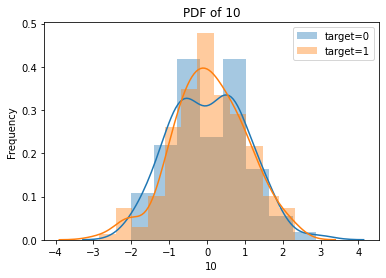

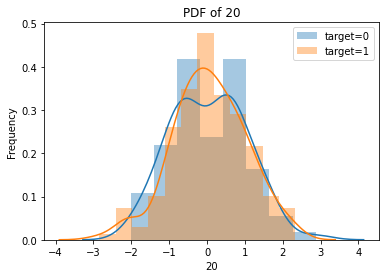

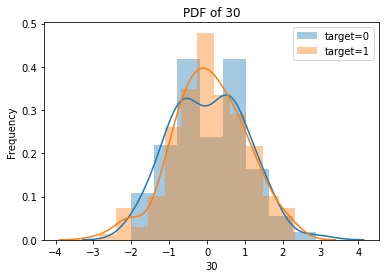

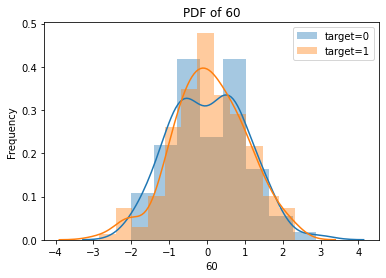

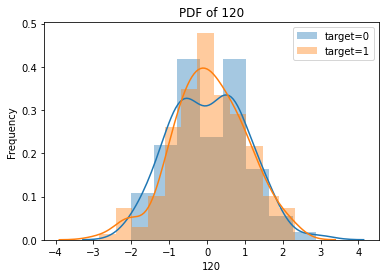

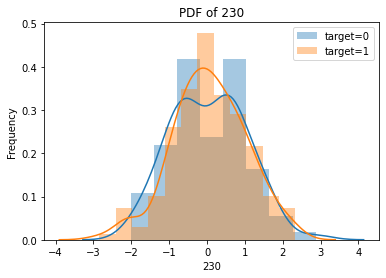

In [21]:
#Reveal some pattern about those that failed and those that did not
for col in ['10','20', '30','60', '120', '230']:
    sns.distplot(train[train['target']==0][str(r[0])], label='target=0')
    sns.distplot(train[train['target']==1][str(r[0])], label='target=1')
    plt.legend(loc='upper right')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.title('PDF of {}'.format(col))
    plt.show()

The target 1 and 0 overlaps, this will make it harder to get a good prediction on the data set.

### Feature Engineering

In [22]:
def feature_eng(df, if_test=False):
    """
    Parameter:
    df: dataframe on which the feature engineering is to be performed
    if_test: A boolean True if the dataframe is the test set or False if it is the train set 
    
    Return:
    Addition columns such as:
    mean: mean of the entire columns,
    std: standarad deviation of the entire column,
    mean_sin: mean of the sine,
    mean_cos: mean of the cosine,
    mean_tan: mean of the tangent,
    mean_sinh: mean of the sinh
    mean_cosh: mean of the cosh,
    mean_tanh: mean of the tanh,
    mean_exp: mean of the exponential
    mean_expm1: mean of exp(x)-1
    mean_exp2: mean of 2**x
    mean_x2: mean of x raise to power 2
    mean_x3: mean of x raise to power 3
    mean_x4: mean of x raise to power 4
    """

    if if_test:
      temp = df.drop(['id'], axis=1)
    else:
      temp = df.drop(['id','target'], axis=1)

    df['mean'] = np.mean(temp, axis=1)
    df['std'] = np.std(temp, axis=1)
    sin_temp = np.sin(temp)
    cos_temp = np.cos(temp)
    tan_temp = np.tan(temp)
    df['mean_sin'] = np.mean(sin_temp, axis=1)
    df['mean_cos'] = np.mean(cos_temp, axis=1)
    df['mean_tan'] = np.mean(tan_temp, axis=1)
    sinh_temp = np.sinh(temp)
    cosh_temp = np.cosh(temp)
    tanh_temp = np.tanh(temp)
    df['mean_sinh'] = np.mean(sinh_temp, axis=1)
    df['mean_cosh'] = np.mean(cosh_temp, axis=1)
    df['mean_tanh'] = np.mean(tanh_temp, axis=1)
    exp_temp = np.exp(temp)
    expm1_temp = np.expm1(temp)
    exp2_temp = np.exp2(temp)
    df['mean_exp'] = np.mean(exp_temp, axis=1)
    df['mean_expm1'] = np.mean(expm1_temp, axis=1)
    df['mean_exp2'] = np.mean(exp2_temp, axis=1)
    df['mean_x2'] = np.mean(np.power(temp,2), axis=1)
    df['mean_x3'] = np.mean(np.power(temp,3), axis=1)
    df['mean_x4'] = np.mean(np.power(temp,4), axis=1)
    return df

In [24]:
train_to_fe = train.copy()
train_fe = feature_eng(train_to_fe,False)
print("Feature engineering performed on train")
test_to_fe = test.copy()
test_fe = feature_eng(test_to_fe, True)
print("Feature engineering performed on test")

Feature engineering performed on train
Feature engineering performed on test


## Modeling

In [27]:
# Raw Data
y = train['target']
train_drop = train.drop(['id', 'target'], axis=1)
test_drop = test.drop(['id'], axis=1)
df_train = train_drop.copy()
y_train = y.copy()
print(df_train.shape)
print(y_train.shape)

(250, 300)
(250,)


In [28]:
scale = StandardScaler()
df_train_scaled = scale.fit_transform(df_train)
print("Train data scaled")
test_scaled = scale.transform(test_drop)
print("Test data scaled")


Train data scaled
Test data scaled


### Baseline Model - Logistic Regression

In [31]:
log_reg = LogisticRegression(random_state=seed)
log_reg.fit(df_train_scaled,y_train)

LogisticRegression(random_state=42)

#### Standardization + ML Classification model without top features

In [19]:
def hyperparameter_model(models, params):
    '''
    Hyperparameter tuning with StratifiedKFold follow by GridSearchCV follow by CalibratedClassifier
    
    Parameters:
    models: Instance of the model
    params: list of parameters with value fr tuning (dict)
    
    Return:
    grid_clf: return gridsearch model    
    '''
    # Random shuffle after every iteration with stratify
    str_cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=42)
    # Find the right hyperparameter for the model
    grid_clf = GridSearchCV(models, params, cv=str_cv, return_train_score=True, scoring='roc_auc')
    # Fit on train data
    grid_clf.fit(df_train_scaled, y_train)
    return grid_clf

In [20]:

def forward_selection_model(model, top_n=10):
    # List of top feature column variable
    top_column = []
    # To store cross val score
    exist_score = 0
    # Iterate over till number of top feature desired
    for n in range(top_n):
        print('for {} feature'.format(n+1))
        flag = 0
        # Iterate over all the feature in train data
        for i in tqdm.tqdm_notebook(range(test_scaled.shape[1])):
            # Finding for first top feature
            if len(top_column) == 0:
                str_cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=42)
                score = cross_val_score(model,df_train_scaled[:,[i]],y_train,cv=str_cv,scoring='roc_auc')
                if exist_score < np.mean(score):
                    top_current = i
                    exist_score = np.mean(score)
                    flag = 1
            # Excluded apart from top column
            elif i not in top_column:
                str_cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=42)
                score = cross_val_score(model,df_train_scaled[:,np.concatenate((top_column,[i]))],y_train,cv=str_cv,scoring='roc_auc')
                if exist_score < np.mean(score):
                    top_current = i
                    exist_score = np.mean(score)
                    flag = 1
        
        if flag == 1:
            print('Current top feature {} and score: {}'.format(top_current,exist_score))
            print('Appended to top column')
            top_column.append(top_current)
            print(top_column)
        else:
            break
    return top_column

In [21]:
def plot_feature_importance(model, model_name, top_n = 10):
    '''
    Compute ROC curve and ROC area for each class
    
    Parameters:
    try_true: train true label
    try_pred: train predict probabilities value
    cvy_true: cv true label
    cvy_pred: cv predict probabilities value
    n_classes: number of unique classes
    
    Return:
    Plot of ROC Curve for train and cv data    
    '''       
    column_name = train.drop(['id','target'], axis=1).columns
    if model_name == 'log_model':
        feat_imp_coef = model.coef_.ravel()
    else:
        feat_imp_coef = model.feature_importances_
    temp = pd.DataFrame(data=np.column_stack((column_name, feat_imp_coef)), columns=['col_name','coef'])
    temp = temp.sort_values(by='coef', ascending=False).reset_index()
    df = temp
    temp = temp[:top_n]
    plt.figure(figsize=(20,5))
    sns.barplot(data=temp, y='coef', x='col_name', order=temp['col_name'])
    plt.grid()
    plt.show()
    return df

### Logistic Regression


> With all features



In [22]:
# List of hyperparameter that has to be tuned
params = {'penalty':['l1', 'l2', 'elasticnet'], 'C':[10**i for i in range(-4,5)], 'solver':['liblinear','sag']}
# Instance of Logsitic Regression
log_model = LogisticRegression(random_state=42, class_weight='balanced')
# Call hyperparameter to get the best parameters of this model
log_clf = hyperparameter_model(log_model, params)

In [23]:
print(log_clf.best_params_)

{'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}


In [24]:
log_model = LogisticRegression(**log_clf.best_params_, class_weight='balanced', random_state=42)
log_model.fit(df_train_scaled, y_train)

LogisticRegression(C=0.1, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=42, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [25]:
clf = CalibratedClassifierCV(log_clf, cv=3)
clf.fit(df_train_scaled, y_train)

CalibratedClassifierCV(base_estimator=GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=5, n_splits=10, random_state=42),
                                                   error_score=nan,
                                                   estimator=LogisticRegression(C=1.0,
                                                                                class_weight='balanced',
                                                                                dual=False,
                                                                                fit_intercept=True,
                                                                                intercept_scaling=1,
                                                                                l1_ratio=None,
                                                                                max_iter=100,
                                                                                multi_class='auto',
                                    

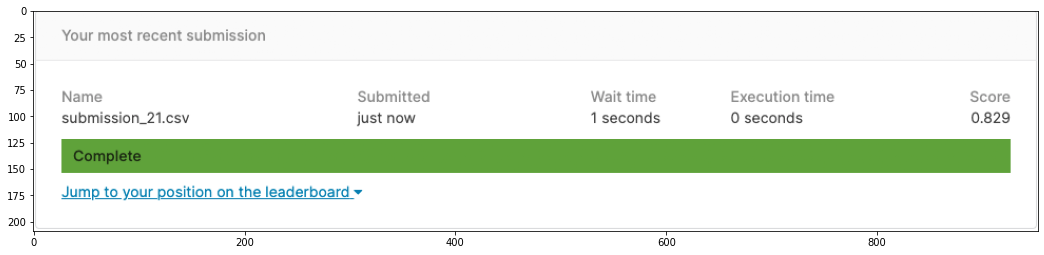

In [26]:
image = plt.imread('with_all_data.png')
plt.figure(figsize=(18,5))
plt.imshow(image)

score was 0.829 with all the data scaled for logistic regression.



> With top 10 features



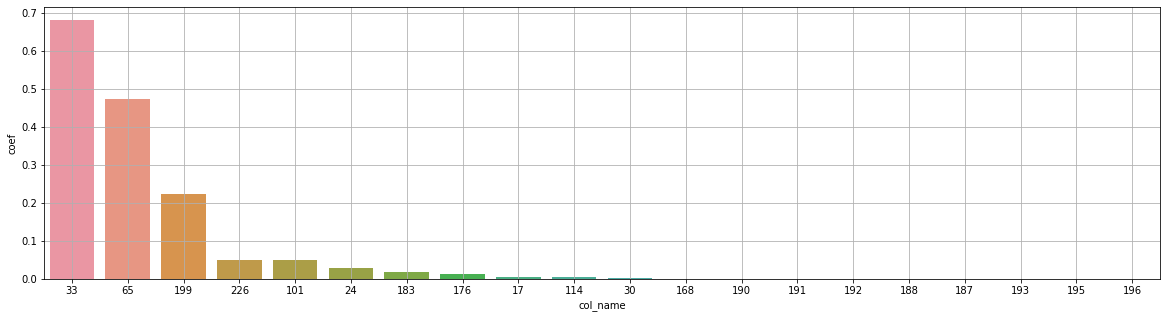

In [27]:
df = plot_feature_importance(log_model, 'log_model', 20)

In [28]:
top_column = forward_selection_model(log_model)

for 1 feature


  0%|          | 0/300 [00:00<?, ?it/s]

Current top feature 33 and score: 0.7347222222222222
Appended to top column
[33]
for 2 feature


  0%|          | 0/300 [00:00<?, ?it/s]

Current top feature 65 and score: 0.7876388888888887
Appended to top column
[33, 65]
for 3 feature


  0%|          | 0/300 [00:00<?, ?it/s]

Current top feature 217 and score: 0.8005555555555557
Appended to top column
[33, 65, 217]
for 4 feature


  0%|          | 0/300 [00:00<?, ?it/s]

Current top feature 117 and score: 0.8156944444444443
Appended to top column
[33, 65, 217, 117]
for 5 feature


  0%|          | 0/300 [00:00<?, ?it/s]

Current top feature 91 and score: 0.8325
Appended to top column
[33, 65, 217, 117, 91]
for 6 feature


  0%|          | 0/300 [00:00<?, ?it/s]

Current top feature 73 and score: 0.8423611111111111
Appended to top column
[33, 65, 217, 117, 91, 73]
for 7 feature


  0%|          | 0/300 [00:00<?, ?it/s]

Current top feature 16 and score: 0.8493055555555555
Appended to top column
[33, 65, 217, 117, 91, 73, 16]
for 8 feature


  0%|          | 0/300 [00:00<?, ?it/s]

Current top feature 226 and score: 0.852777777777778
Appended to top column
[33, 65, 217, 117, 91, 73, 16, 226]
for 9 feature


  0%|          | 0/300 [00:00<?, ?it/s]

Current top feature 82 and score: 0.8559722222222222
Appended to top column
[33, 65, 217, 117, 91, 73, 16, 226, 82]
for 10 feature


  0%|          | 0/300 [00:00<?, ?it/s]

Current top feature 90 and score: 0.8590277777777778
Appended to top column
[33, 65, 217, 117, 91, 73, 16, 226, 82, 90]


In [29]:
# Store the top column name into set
log_top10_feat = set(top_column)
# Fit Logistic Regression on top features only
log_model_top = LogisticRegression(**log_clf.best_params_, class_weight='balanced', random_state=42)
log_model_top.fit(df_train_scaled[:,top_column],y_train)
# Calibrate it in top features only
clf = CalibratedClassifierCV(log_model_top, cv=3)
clf.fit(df_train_scaled[:,top_column],y_train)
# Predict the probabilities of 1
test_pred = clf.predict_proba(test_scaled[:,top_column])[:,1]

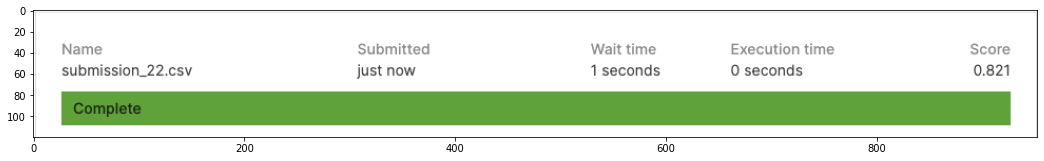

In [30]:
image = plt.imread('with_top_10.png')
plt.figure(figsize=(18,5))
plt.imshow(image)

### Logistic Regression with Feature Engineered Data


> With All Data



In [31]:
y_train_fe = train_fe['target']
train_drop_fe = train_fe.drop(['id', 'target'], axis=1)
test_drop_fe = test_fe.drop(['id'], axis=1)

In [32]:
train_fe_scaled = scale.fit_transform(train_drop_fe)
test_fe_scaled = scale.transform(test_drop_fe)

In [33]:
log_model_fe = LogisticRegression(**log_clf.best_params_, class_weight='balanced', random_state=42)
log_model_fe.fit(train_fe_scaled, y_train_fe)

LogisticRegression(C=0.1, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=42, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
clf_fe = CalibratedClassifierCV(log_clf, cv=3)
clf_fe.fit(train_fe_scaled, y_train_fe)

In [ ]:
image = plt.imread('eng_feat_all_data.png')
plt.figure(figsize=(18,5))
plt.imshow(image)



> With top 10 feats



In [ ]:
top_column_fe = forward_selection_model(log_model_fe)

In [ ]:
# Store the top column name into set
log_top10_feat_fe = set(top_column_fe)
# Fit Logistic Regression on top features only
log_model_top_fe = LogisticRegression(**log_clf.best_params_, class_weight='balanced', random_state=42)
log_model_top_fe.fit(df_train_scaled[:,top_column_fe],y_train_fe)
# Calibrate it in top features only
clf_fe = CalibratedClassifierCV(log_model_top_fe, cv=3)
clf_fe.fit(train_fe_scaled[:,top_column],y_train_fe)
# Predict the probabilities of 1
test_pred_fe = clf_fe.predict_proba(test_fe_scaled[:,top_column])[:,1]

In [ ]:
image = plt.imread('eng_feat_top10.png')
plt.figure(figsize=(18,5))
plt.imshow(image)

### RandomForest 


> with all data



In [39]:
# List of hyperparameter that has t be tuned
params = {'n_estimators':[10,20,30,40,50,100,200,300,400],'max_depth':[2,3,5,7]}
# Instance of randomforest
rf_model = RandomForestClassifier(random_state=42)
# Perform GridSearchCV to find best parameters
rf_clf = hyperparameter_model(rf_model, params)

In [40]:
print(rf_clf.best_params_)

{'max_depth': 2, 'n_estimators': 300}


In [41]:
rf_clf = RandomForestClassifier(**rf_clf.best_params_,random_state=42)
rf_clf.fit(df_train_scaled, y_train)
clf = CalibratedClassifierCV(rf_clf, cv=3)
clf.fit(df_train_scaled, y_train)

CalibratedClassifierCV(base_estimator=RandomForestClassifier(bootstrap=True,
                                                             ccp_alpha=0.0,
                                                             class_weight=None,
                                                             criterion='gini',
                                                             max_depth=2,
                                                             max_features='auto',
                                                             max_leaf_nodes=None,
                                                             max_samples=None,
                                                             min_impurity_decrease=0.0,
                                                             min_impurity_split=None,
                                                             min_samples_leaf=1,
                                                             min_samples_split=2,
                                  

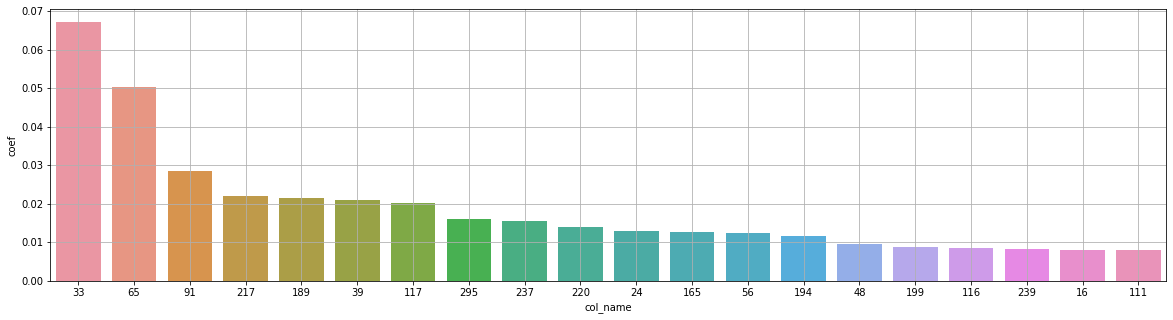

In [42]:
df = plot_feature_importance(rf_clf, 'rf',20)

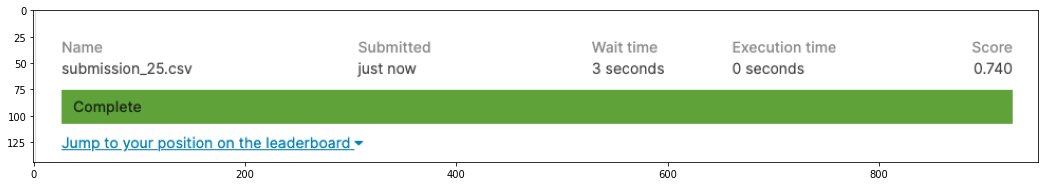

In [43]:
image = plt.imread('rf_with all_data.png')
plt.figure(figsize=(18,5))
plt.imshow(image)

### XGBoost Classifier

In [ ]:
from xgboost import XGBClassifier

# Xgboost (See Docs: https://xgboost.readthedocs.io/en/latest/python/python_api.html)

# List of hyperparameter that has to be tuned
params = {'max_depth':[2,3,5,7], 'n_estimators':[10,20,50,100,200,300,400]}
# Instance of XGBoost Model
xgb_model = XGBClassifier(scale_pos_weight=0.5)
# Call hyperparameter to find the best parameters
xgb_clf = hyperparameter_model(xgb_model, params)

In [ ]:
print(xgb_clf.best_params_)
print('cv Score',xgb_clf.score(df_train_scaled, y_train))

In [ ]:
rf_clf = RandomForestClassifier(**rf_clf.best_params_,random_state=42)
rf_clf.fit(df_train_scaled, y_train)
clf = CalibratedClassifierCV(rf_clf, cv=3)
clf.fit(df_train_scaled, y_train)

In [ ]:
# # Create a submssion format to make submission in Kaggle
# temp_id = test['id']
# log_csv = clf.predict_proba(test_scaled)[:,1]
# log_df = pd.DataFrame(np.column_stack((temp_id,log_csv)), columns=['id','target'])
# log_df['id'] = log_df['id'].astype('int32')
# log_df.to_csv('submission_25.csv', index=False)

In [ ]:
# # Create a submssion format to make submission in Kaggle
# temp_id = test['id']
# log_csv = clf.predict_proba(test_scaled)[:,1]
# log_df = pd.DataFrame(np.column_stack((temp_id,log_csv)), columns=['id','target'])
# log_df['id'] = log_df['id'].astype('int32')
# log_df.to_csv('submission_23.csv', index=False)

In [ ]:
# temp_id = test['id']
# df_tspred = pd.DataFrame(np.column_stack((temp_id,test_pred_fe)), columns=['id','target'])
# df_tspred['id'] = df_tspred['id'].astype('int32')
# df_tspred.to_csv('submission_24.csv', index=False)